<a href="https://colab.research.google.com/github/xoxominji/22-1-ESAA-Practice/blob/main/0620_%EB%B0%95%EB%AF%BC%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [필사]

## 파이썬 딥러닝 텐서플로 PART04 합성곱 신경망(CNN)

### 3.1 합성곱 신경망

CNN(Convolutional Neural Network): 데이터가 가진 특징들의 패턴을 합습하는 알고리즘

<예시>
- 이미지 분류: 클래스 예측
- 객체 탐지(미지이에서 특정한 객체를 인식하고 이미지의 어디에 있는지 위치를 파악하는 기술): 위치 좌표는 회귀분석, 클래스 예측은 분류
- 스타일 전이: 콘텐츠 이미지 + 스타일 참조 이미지 이용해 콘텐츠의 기본 ㅕㅇ태를 유지하고 스타일을 입혀서 새로운 이미지를 생성하는 기술

#### **1) 이미지 표현**

: 이미지(영상)을 컴퓨터가 이해할 수 있도록 숫자로 표현

- 픽셀의 화소 값: 0(검) ~ 255(흰)-이미지 강도
   - 컬러: R G B

#### **2) 합성곱(Convolution)**

: 입력 이미지에 대한 특성 추출 -> "특성맵(feature map)"

- 입력 이미지(n*n)와 
커널(m*m)이 겹치는 부분에 대한 합성곱 연산 수행 (n>m)
  - 합성곱 연산: element-wise 곱셈 연산의 합
- n^2개의 가중치로 커널의 가중치 업데이트


#### **3) 채널(channel)**

: 입력 이미지를 구성하는 2차원 배열의 개수

- 흑백: 채널 1개
- 컬러: 채널 R,G,B 3개

입력 이미지의 채널 개수만큼 합성곱 연산이 진행, 만약 2개 이상이면 합성곱 연산 결과 값을 element-wise 덧셈 연산으로 최종 특성맵 생성


가중치 그래디언트 수 = 입력 이미지 shape x 입력 이미지 채널 개수 x 출력 필터 개수 + bias

#### **4) 스트라이드(stride)**

: 커널이 좌측에서 우측으로 이동하면서 합성곱 연산을 할 때의 이동 간격

움직이는만큼 특성맵의 크기가 1/n으로 감소


#### **5) 패딩(padding)**
: 특성맵의 크기가 입력 임이지 대비 줄어들지 않도록 

기존) 입력 이미지(n*n) -> 
커널(m*m) -> 
특성맵(n-m+1)*(n-m+1) if stride=1

#### **6) 특성맵(feature map) 사이즈**

$(Output Height, Output Width)=(\frac{Image Height + 2P - Kernel Height}{S}+1, \frac{Image Height + 2P - Kernel Height}{S}+1)$

#### **7) 풀링(pooling)**

: 추츨된 특성맵을 다운 샘플링하여 이미지 크기를 축소하는 레이어

효과: 과대적합 방지, 연산량 감소

<종류>
- 최대 풀링(max pooling)
- 평균 풀링(average pooling)

스트라이드 설정 가능

### 3.2 간단한 모델 생성

#### 데이터 로드 및 전처리

In [1]:
# tensorflow 모듈 import 
import tensorflow as tf

In [2]:
# MNIST 손글씨 이미지 데이터 로드
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


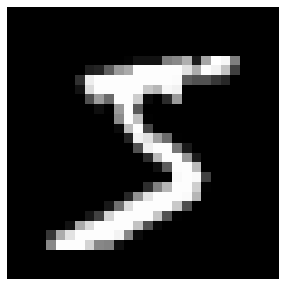

In [3]:
# 샘플 이미지 출력
import matplotlib.pylab as plt

def plot_image(data, idx):
    plt.figure(figsize=(5, 5))
    plt.imshow(data[idx], cmap="gray")
    plt.axis("off")
    plt.show()

plot_image(x_train, 0)

In [4]:
print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0 255
0 255


In [5]:
# 정규화(Normalization): 모델의 안정적인 학습을 위해
x_train = x_train / 255.0
x_valid = x_valid / 255.0

print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0.0 1.0
0.0 1.0


In [6]:
# 채널 추가
print(x_train.shape, x_valid.shape)

x_train_in = x_train[..., tf.newaxis] #축 추가
x_valid_in = x_valid[..., tf.newaxis]

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


#### Sequential API로 모델 생성 및 학습

- 합성곱 레이어 1개: `tf.keras.layers.Conv2D(커널 수, (가로, 세로), ...)`
- 풀링 레이어 1개(최대 풀링): `tf.keras.layers.MaxPooling2D((가로, 세로))`
- 1차원 배열: 분류 위함 `tf.keras.layers.Flatten()` 
- 분류기: `tf.keras.layers.Dense(분류 수, 활성화함수)`


In [7]:
# Sequential API를 사용하여 샘플 모델 생성
model = tf.keras.Sequential([
    # Convolution 적용 (32 filters)
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', 
                           input_shape=(28, 28, 1), name='conv'),
    # Max Pooling 적용
    tf.keras.layers.MaxPooling2D((2, 2), name='pool'),
    # Classifier 출력층 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax'),
])

In [8]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(x_train_in, y_train, 
                    validation_data=(x_valid_in, y_valid), 
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.2094 - accuracy: 0.9406 - val_loss: 0.0978 - val_accuracy: 0.9705
Epoch 2/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.0789 - accuracy: 0.9771 - val_loss: 0.0651 - val_accuracy: 0.9799
Epoch 3/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0600 - accuracy: 0.9826 - val_loss: 0.0577 - val_accuracy: 0.9817
Epoch 4/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0494 - accuracy: 0.9854 - val_loss: 0.0519 - val_accuracy: 0.9823
Epoch 5/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0423 - accuracy: 0.9876 - val_loss: 0.0546 - val_accuracy: 0.9826
Epoch 6/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0359 - accuracy: 0.9890 - val_loss: 0.0520 - val_accuracy: 0.9827
Epoch 7/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0305 - accuracy: 0.9908 - val_loss: 0.0535 -

In [9]:
model.evaluate(x_valid_in, y_valid)

313/313 [==============================] - 1s 4ms/step - loss: 0.0553 - accuracy: 0.9838


[0.05527438223361969, 0.9837999939918518]

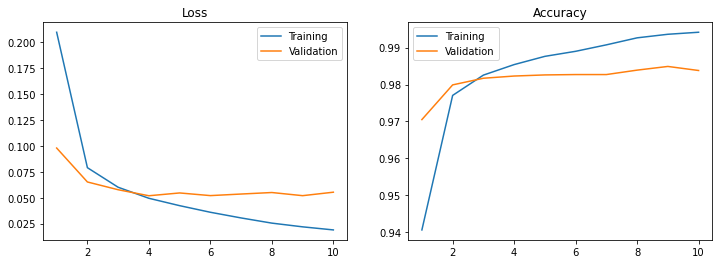

In [10]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 10)

> 4 epoch 이후부터 모델 과대적합

#### 모델 구조 파악

In [11]:
# 모델 구조 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2D)               (None, 26, 26, 32)        320       
                                                                 
 pool (MaxPooling2D)         (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [12]:
# 입력 텐서 형태 
model.input
#None= 배치 크기가 들어오는 위치로 어떤 값이든 가능

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

In [13]:
# 출력 텐서 형태 
model.output

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense')>

In [14]:
# 레이어 
model.layers
#파이썬 리스트 형태로

In [15]:
# 첫번째 레이어 선택
model.layers[0]

In [16]:
# 첫번째 레이어 입력
model.layers[0].input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

In [17]:
# 첫번째 레이어 출력
model.layers[0].output

<KerasTensor: shape=(None, 26, 26, 32) dtype=float32 (created by layer 'conv')>

In [18]:
# 첫번째 레이어 가중치
model.layers[0].weights

[<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[-0.8032573 , -0.09383649,  0.3798673 ,  0.24732338,
            0.37135324,  0.1857117 ,  0.08701344, -1.1203039 ,
           -0.63546056, -0.12824273,  0.25932577,  0.71917105,
           -0.48705775,  0.4978883 ,  0.26045915,  0.2745909 ,
           -0.07341665, -0.6397793 , -0.7127322 , -0.306933  ,
           -0.62649226, -0.5317066 ,  0.1210734 ,  0.02616824,
            0.24343488, -0.67697793, -0.06470305,  0.18021119,
            0.08812284,  0.31613407, -1.1291407 , -0.44175798]],
 
         [[-0.3518155 , -0.08830106,  0.19208896,  0.10535999,
            0.50199604, -0.5192895 ,  0.44693223, -0.6419748 ,
           -0.03376039,  0.39609417,  0.26585844,  0.50301474,
            0.10885861, -0.12109557,  0.15572208,  0.16540946,
            0.2354637 ,  0.14469588, -0.6439225 ,  0.1579534 ,
           -0.68760633, -0.16931273,  0.48374748,  0.58964473,
            0.33725625, -0.7640292 ,  0.12

In [19]:
# 첫번째 레이어 커널 가중치
model.layers[0].kernel

<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
array([[[[-0.8032573 , -0.09383649,  0.3798673 ,  0.24732338,
           0.37135324,  0.1857117 ,  0.08701344, -1.1203039 ,
          -0.63546056, -0.12824273,  0.25932577,  0.71917105,
          -0.48705775,  0.4978883 ,  0.26045915,  0.2745909 ,
          -0.07341665, -0.6397793 , -0.7127322 , -0.306933  ,
          -0.62649226, -0.5317066 ,  0.1210734 ,  0.02616824,
           0.24343488, -0.67697793, -0.06470305,  0.18021119,
           0.08812284,  0.31613407, -1.1291407 , -0.44175798]],

        [[-0.3518155 , -0.08830106,  0.19208896,  0.10535999,
           0.50199604, -0.5192895 ,  0.44693223, -0.6419748 ,
          -0.03376039,  0.39609417,  0.26585844,  0.50301474,
           0.10885861, -0.12109557,  0.15572208,  0.16540946,
           0.2354637 ,  0.14469588, -0.6439225 ,  0.1579534 ,
          -0.68760633, -0.16931273,  0.48374748,  0.58964473,
           0.33725625, -0.7640292 ,  0.12448678,  0.093955

In [20]:
# 첫번째 레이어 bias 가중치
model.layers[0].bias

<tf.Variable 'conv/bias:0' shape=(32,) dtype=float32, numpy=
array([-0.22169752,  0.        , -0.22387472, -0.23547764, -0.00627422,
       -0.13574724, -0.19897297, -0.07563835, -0.06812058, -0.22889408,
       -0.13895006,  0.07964161, -0.06622268,  0.09643019, -0.38858423,
       -0.33375335, -0.2723358 , -0.16304934, -0.02811637, -0.25709856,
       -0.01597718, -0.1972587 , -0.1867187 , -0.01359723,  0.01381236,
        0.10452874, -0.17505886, -0.2527127 , -0.2592407 , -0.38877133,
       -0.05182672, -0.06065455], dtype=float32)>

In [21]:
# 레이어 이름 사용하여 레이어 선택
model.get_layer('conv')

In [22]:
# 샘플 이미지의 레이어별 출력을 리스트에 추가 (첫번째, 두번째 레이어)
activator = tf.keras.Model(inputs=model.input, 
                           outputs=[layer.output for layer in model.layers[:2]] ) 
activations = activator.predict(x_train_in[0][tf.newaxis, ...]) 

len(activations)

2

In [23]:
# 첫 번째 레이어(conv) 출력층 
conv_activation = activations[0]
conv_activation.shape

(1, 26, 26, 32)

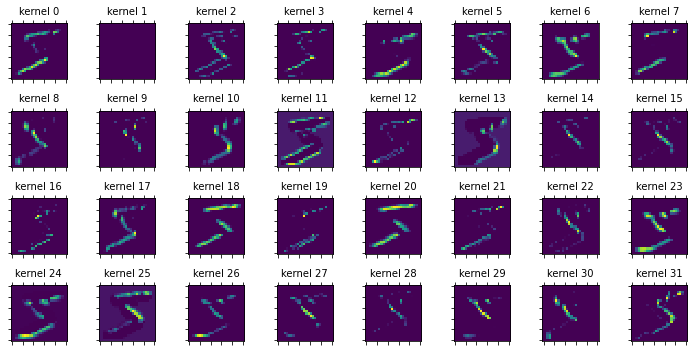

In [24]:
# Convolution 시각화
fig, axes = plt.subplots(4, 8)
fig.set_size_inches(10, 5)

for i in range(32):
    axes[i//8, i%8].matshow(conv_activation[0, :, :, i], cmap='viridis')
    axes[i//8, i%8].set_title('kernel %s'%str(i), fontsize=10)
    plt.setp( axes[i//8, i%8].get_xticklabels(), visible=False)
    plt.setp( axes[i//8, i%8].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

In [25]:
# 두 번째 레이어(pool) 출력층 
pooling_activation = activations[1]
print(pooling_activation.shape)

(1, 13, 13, 32)


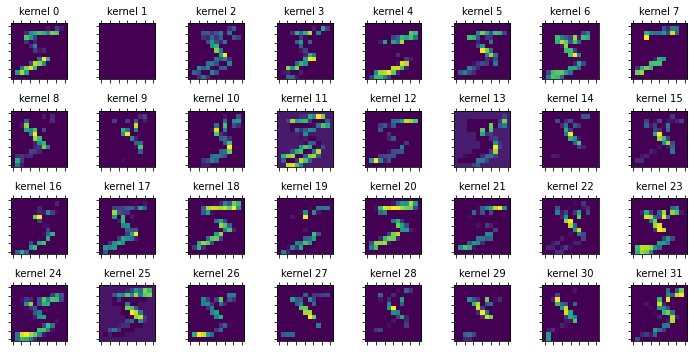

In [26]:
# 시각화
fig, axes = plt.subplots(4, 8)
fig.set_size_inches(10, 5)

for i in range(32):
    axes[i//8, i%8].matshow(pooling_activation[0, :, :, i], cmap='viridis')
    axes[i//8, i%8].set_title('kernel %s'%str(i), fontsize=10)
    plt.setp( axes[i//8, i%8].get_xticklabels(), visible=False)
    plt.setp( axes[i//8, i%8].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

### 3.3 복잡한 모델 생성 : Functional API

#### 1) 데이터셋 준비

In [27]:
import tensorflow as tf
import numpy as np

In [28]:
# MNIST 손글씨 이미지 데이터 로드
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [29]:
# 새로운 출력값 배열을 생성 (홀수: 1, 짝수: 0)
y_train_odd = []
for y in y_train:
    if y % 2==0:
        y_train_odd.append(0)
    else:
        y_train_odd.append(1)

y_train_odd = np.array(y_train_odd)
y_train_odd.shape

(60000,)

In [31]:
print(y_train[:10])
print(y_train_odd[:10])

[5 0 4 1 9 2 1 3 1 4]
[1 0 0 1 1 0 1 1 1 0]


In [30]:
# Validation 데이터셋 처리
y_valid_odd = []
for y in y_valid:
    if y % 2==0:
        y_valid_odd.append(0)
    else:
        y_valid_odd.append(1)

y_valid_odd = np.array(y_valid_odd)
y_valid_odd.shape

(10000,)

In [32]:
# 정규화(Normalization)
x_train = x_train / 255.0
x_valid = x_valid / 255.0

# 채널 추가
x_train_in = tf.expand_dims(x_train, -1)
x_valid_in = tf.expand_dims(x_valid, -1)

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


#### 2) Functional API로 다중 입력, 다중 출력 레이어 생성

In [33]:
# Functional API를 사용하여 모델 생성

inputs = tf.keras.layers.Input(shape=(28, 28, 1))

conv = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs) #1st출력
pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)
flat = tf.keras.layers.Flatten()(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs) #2nd출력
concat = tf.keras.layers.Concatenate()([flat, flat_inputs]) #두 출력 합쳐지기
outputs = tf.keras.layers.Dense(10, activation='softmax')(concat)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 26, 26, 32)   320         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 13, 13, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 flatten_1 (Flatten)            (None, 5408)         0           ['max_pooling2d[0][0]']          
                                                                                            

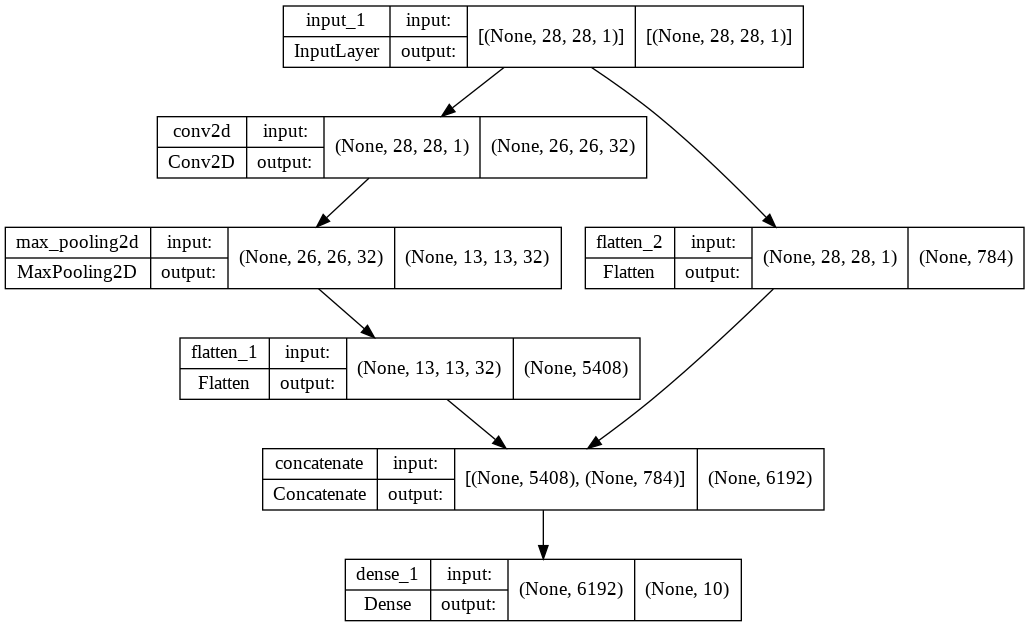

In [36]:
# 모델 구조 출력 및 이미지 파일로 저장
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='functional_cnn.png')

In [37]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(x_train_in, y_train, 
                    validation_data=(x_valid_in, y_valid), 
                    epochs=10)

# 모델 성능
val_loss, val_acc = model.evaluate(x_valid_in, y_valid)
print(val_loss, val_acc)

Epoch 1/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1924 - accuracy: 0.9460 - val_loss: 0.0786 - val_accuracy: 0.9769
Epoch 2/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0739 - accuracy: 0.9781 - val_loss: 0.0643 - val_accuracy: 0.9810
Epoch 3/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0582 - accuracy: 0.9826 - val_loss: 0.0644 - val_accuracy: 0.9783
Epoch 4/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0473 - accuracy: 0.9858 - val_loss: 0.0574 - val_accuracy: 0.9814
Epoch 5/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0396 - accuracy: 0.9882 - val_loss: 0.0549 - val_accuracy: 0.9826
Epoch 6/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0333 - accuracy: 0.9895 - val_loss: 0.0594 - val_accuracy: 0.9827
Epoch 7/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0282 - accuracy: 0.9911 - val_loss: 0.0632 -

#### 3) 다중 출력 분류 모델

- 출력 1 : 0 ~ 9 까지 숫자 예측
- 출력 2: 각 숫자가 홀수인지 짝수인지 예측

In [38]:
# Functional API를 사용하여 모델 생성

inputs = tf.keras.layers.Input(shape=(28, 28, 1), name='inputs')

conv = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_layer')(inputs)
pool = tf.keras.layers.MaxPooling2D((2, 2), name='maxpool_layer')(conv)
flat = tf.keras.layers.Flatten(name='flatten_layer')(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])
digit_outputs = tf.keras.layers.Dense(10, activation='softmax', name='digit_dense')(concat)

odd_outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='odd_dense')(flat_inputs)

model = tf.keras.models.Model(inputs=inputs, outputs=[digit_outputs, odd_outputs])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_layer (Conv2D)          (None, 26, 26, 32)   320         ['inputs[0][0]']                 
                                                                                                  
 maxpool_layer (MaxPooling2D)   (None, 13, 13, 32)   0           ['conv2d_layer[0][0]']           
                                                                                                  
 flatten_layer (Flatten)        (None, 5408)         0           ['maxpool_layer[0][0]']          
                                                                                            

In [39]:
# 모델의 입력과 출력을 나타내는 텐서
print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'digit_dense')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'odd_dense')>]


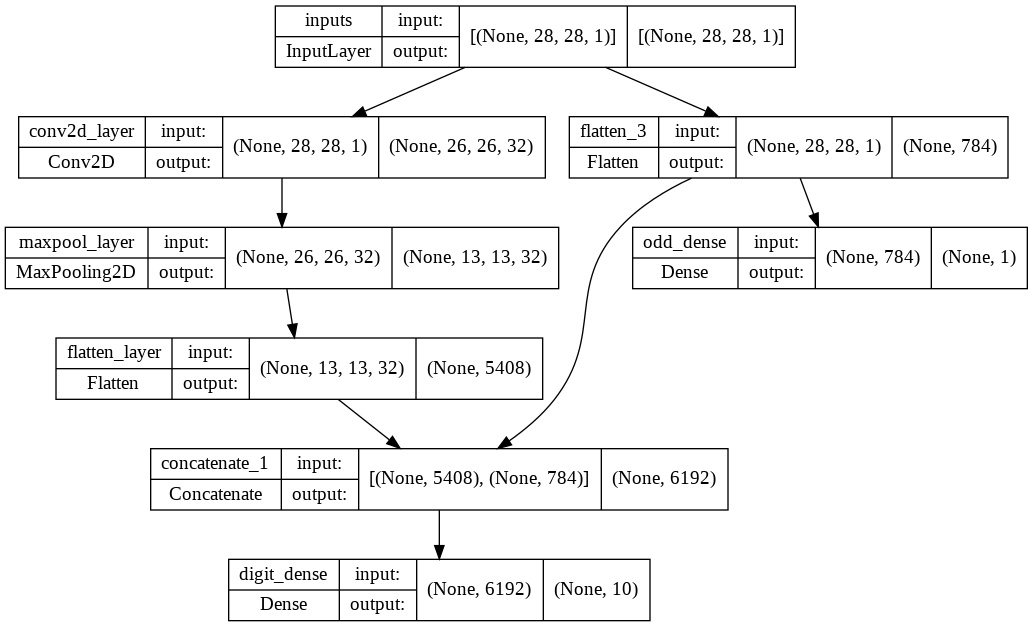

In [40]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='multi_output_cnn.png')

In [41]:
# 모델 컴파일
model.compile(optimizer='adam', 
              loss={'digit_dense': 'sparse_categorical_crossentropy', 'odd_dense': 'binary_crossentropy'}, 
              loss_weights={'digit_dense': 1, 'odd_dense': 0.5}, # loss = 1.0 *sparse_categorical_crossentropy + 0.5*binary_crossentropy
              metrics=['accuracy'])

# 모델 훈련
history = model.fit({'inputs': x_train_in}, {'digit_dense': y_train, 'odd_dense': y_train_odd}, 
                    validation_data=({'inputs': x_valid_in},  {'digit_dense': y_valid, 'odd_dense': y_valid_odd}), 
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3571 - digit_dense_loss: 0.1920 - odd_dense_loss: 0.3303 - digit_dense_accuracy: 0.9463 - odd_dense_accuracy: 0.8608 - val_loss: 0.2330 - val_digit_dense_loss: 0.0936 - val_odd_dense_loss: 0.2787 - val_digit_dense_accuracy: 0.9721 - val_odd_dense_accuracy: 0.8897
Epoch 2/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2086 - digit_dense_loss: 0.0724 - odd_dense_loss: 0.2724 - digit_dense_accuracy: 0.9788 - odd_dense_accuracy: 0.8909 - val_loss: 0.1910 - val_digit_dense_loss: 0.0598 - val_odd_dense_loss: 0.2625 - val_digit_dense_accuracy: 0.9803 - val_odd_dense_accuracy: 0.8981
Epoch 3/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1865 - digit_dense_loss: 0.0550 - odd_dense_loss: 0.2631 - digit_dense_accuracy: 0.9830 - odd_dense_accuracy: 0.8946 - val_loss: 0.1928 - val_digit_dense_loss: 0.0628 - val_odd_dense_loss: 0.2600 - val_digit_dense_accuracy: 0.9798 -

In [42]:
# 모델 성능
model.evaluate({'inputs': x_valid_in}, {'digit_dense': y_valid, 'odd_dense': y_valid_odd})

313/313 [==============================] - 1s 4ms/step - loss: 0.1863 - digit_dense_loss: 0.0587 - odd_dense_loss: 0.2551 - digit_dense_accuracy: 0.9840 - odd_dense_accuracy: 0.9022


[0.1862504482269287,
 0.05869436636567116,
 0.25511205196380615,
 0.984000027179718,
 0.9021999835968018]

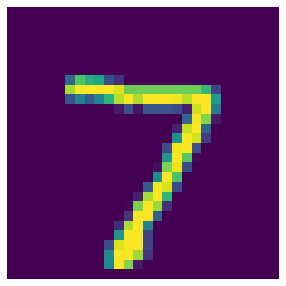

In [43]:
# 샘플 이미지 출력
import matplotlib.pylab as plt

def plot_image(data, idx):
    plt.figure(figsize=(5, 5))
    plt.imshow(data[idx])
    plt.axis("off")
    plt.show()

plot_image(x_valid, 0)

In [44]:
digit_preds, odd_preds = model.predict(x_valid_in)
print(digit_preds[0]) #10개 분류 레이블에 대한 확률
print(odd_preds[0]) #홀수일 확률

[2.9883954e-13 9.3947472e-10 5.6243660e-10 2.4097469e-06 3.3520079e-12
 6.9600321e-13 4.9535081e-21 9.9999762e-01 1.5041768e-09 1.1245032e-08]
[0.99953425]


In [45]:
digit_labels = np.argmax(digit_preds, axis=-1)
digit_labels[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [46]:
odd_labels = (odd_preds > 0.5).astype(np.int).reshape(1, -1)[0]
odd_labels[0:10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


array([1, 0, 1, 0, 0, 1, 0, 1, 0, 1])

#### 4) 전이 학습(Transfer Learning)

: 기존에 학습된 모델을 활용해 새로운 모델을 만들어내기 (by 최종 출력층만 새롭게 추가)

In [47]:
# 앞의 모델에서 flatten_layer 출력을 추출
base_model_output = model.get_layer('flatten_layer').output

# 앞의 출력을 출력으로 하는 모델 정의
base_model = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base')
base_model.summary()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


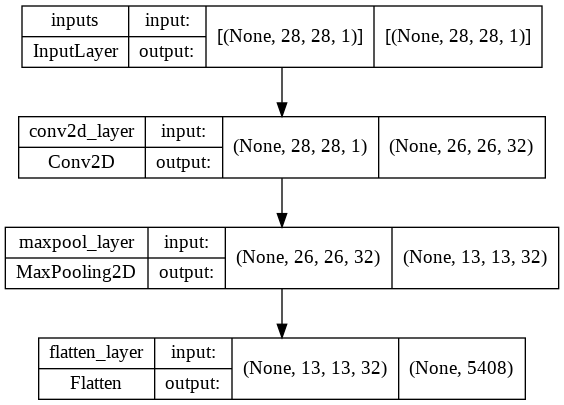

In [48]:
plot_model(base_model, show_shapes=True, show_layer_names=True, to_file='base_model.png')

In [49]:
# Sequential API 적용
digit_model = tf.keras.Sequential([
                                   base_model,
                                   tf.keras.layers.Dense(10, activation='softmax'),
                                   ])
digit_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (Functional)           (None, 5408)              320       
                                                                 
 dense_2 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


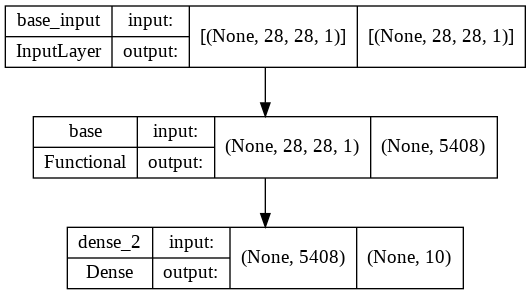

In [50]:
plot_model(digit_model, show_shapes=True, show_layer_names=True, to_file='digit_model.png')

In [51]:
# 모델 컴파일
digit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model.fit(x_train_in, y_train, 
                    validation_data=(x_valid_in, y_valid), 
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.1254 - accuracy: 0.9656 - val_loss: 0.0621 - val_accuracy: 0.9797
Epoch 2/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0563 - accuracy: 0.9831 - val_loss: 0.0567 - val_accuracy: 0.9818
Epoch 3/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0426 - accuracy: 0.9868 - val_loss: 0.0559 - val_accuracy: 0.9810
Epoch 4/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0342 - accuracy: 0.9893 - val_loss: 0.0540 - val_accuracy: 0.9824
Epoch 5/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0281 - accuracy: 0.9910 - val_loss: 0.0542 - val_accuracy: 0.9822
Epoch 6/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0226 - accuracy: 0.9932 - val_loss: 0.0513 - val_accuracy: 0.9829
Epoch 7/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.0187 - accuracy: 0.9941 - val_loss: 0.0544 -

In [52]:
# 베이스 모델의 가중치를 고정 (Freeze Model)

base_model_frozen = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen')
base_model_frozen.trainable = False
base_model_frozen.summary()

Model: "base_frozen"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________________


Flatten 레이어 이전의 Conv2D 레이어의 파라미터는 훈련에 포함시킬 수 없음

In [53]:
# Functional API 적용
dense_output = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen.output)
digit_model_frozen = tf.keras.models.Model(inputs=base_model_frozen.input, outputs=dense_output)
digit_model_frozen.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,090
Non-trainable params: 320
_____________________________________________________

In [54]:
# 모델 컴파일
digit_model_frozen.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model_frozen.fit(x_train_in, y_train, 
                    validation_data=(x_valid_in, y_valid), 
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1140 - accuracy: 0.9692 - val_loss: 0.0587 - val_accuracy: 0.9816
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0475 - accuracy: 0.9860 - val_loss: 0.0512 - val_accuracy: 0.9842
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0346 - accuracy: 0.9895 - val_loss: 0.0520 - val_accuracy: 0.9835
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0264 - accuracy: 0.9919 - val_loss: 0.0534 - val_accuracy: 0.9832
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0214 - accuracy: 0.9937 - val_loss: 0.0511 - val_accuracy: 0.9850
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0168 - accuracy: 0.9951 - val_loss: 0.0542 - val_accuracy: 0.9840
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0139 - accuracy: 0.9957 - val_loss: 0.0541 - val_acc

In [55]:
# 베이스 모델의 Conv2D 레이어의 가중치만 고정 (Freeze Layer)
base_model_frozen2 = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen2')
base_model_frozen2.get_layer('conv2d_layer').trainable = False
base_model_frozen2.summary()

Model: "base_frozen2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________________


In [56]:
# Functional API 적용
dense_output2 = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen2.output)
digit_model_frozen2 = tf.keras.models.Model(inputs=base_model_frozen2.input, outputs=dense_output2)
digit_model_frozen2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,090
Non-trainable params: 320
_____________________________________________________

In [57]:
# 모델 컴파일
digit_model_frozen2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model_frozen2.fit(x_train_in, y_train, 
                    validation_data=(x_valid_in, y_valid), 
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1132 - accuracy: 0.9693 - val_loss: 0.0604 - val_accuracy: 0.9806
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0471 - accuracy: 0.9860 - val_loss: 0.0514 - val_accuracy: 0.9824
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0351 - accuracy: 0.9891 - val_loss: 0.0501 - val_accuracy: 0.9837
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0261 - accuracy: 0.9920 - val_loss: 0.0543 - val_accuracy: 0.9832
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.0512 - val_accuracy: 0.9845
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0171 - accuracy: 0.9946 - val_loss: 0.0513 - val_accuracy: 0.9844
Epoch 7/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0135 - accuracy: 0.9961 - val_loss: 0.0576 - val_acc